**import packages used**

In [4]:
import numpy as np
import random
from pyXRD import pyXRDCodes
from scipy.signal import find_peaks
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Corrected

In [241]:
#============MOD CROSSOVER===========
class Structure:
    def __init__(self, atoms, positions,symmetry, unit_params,unit_angles,theta,hkls,counts,step = 0.01,group_sym=[194]):
        self.atoms = atoms  # List of atom types (e.g., ['Ti', 'C'])
        self.positions = positions  # List of positions for each atom type
        self.unit_params = unit_params  # Unit cell parameters
        self.unit_angles = unit_angles
        self.symnumb = symmetry
        self.symmetry = pyXRDCodes.get_symmetry_operations_number(symmetry)
        self.thetas = theta
        self.hkls = hkls
        self.counts = counts
        self.param_grid = np.arange(0,1,step)
        self.param_step = step
        self.group_sym = group_sym

        self.separate_overlapping_atoms(min_distance=0.1, target_distance=0.25, max_iterations=100)

    def get_primit_unit(self):
        ppos_primit = [
        [ h
            for pos in atom_list
            for h in pyXRDCodes.POS(pos, self.symmetry)
        ]  for atom_list in self.positions    ]
    
        primit = []
        for i in range(len(ppos_primit)):
            pp = []
            verif = []
            for j in range(len(ppos_primit[i])):
                vec = ppos_primit[i][j]
                if 0 <= vec[0] < 1 and 0 <= vec[1] < 1 and 0 <= vec[2] < 1:
                    cart = tuple(np.round(pyXRDCodes.abcToxyz(vec, self.unit_params, self.unit_angles) ,2))
                    if cart not in verif:
                        verif.append(cart)
                        pp.append(pyXRDCodes.abcToxyz(vec, self.unit_params, self.unit_angles))
            primit.append(pp)
        #primit,pos_unit,_ = pyXRDCodes.find_atoms_unit_cell(self.positions, self.unit_params, self.unit_angles, self.symmetry)        
        return primit,self.positions#pos_unit


    #Give the real xyz positions
    def true_positions(self,pos):
        """
        Function to give positions to use in the 'simulate_xrd' function
        """
        positions = []
        for i in range(len(self.atoms)):
            pp = []
            for j in range(len(pos[i])):
                pp.append(pyXRDCodes.abcToxyz(pos[i][j],self.unit_params,self.unit_angles))
            positions.append( pp )
        
        return positions


    # --- Simulation Methods ---
    def calculate_xrd(self, lamb):
        """
        Simulates X-ray diffraction (XRD) pattern based on the structure's parameters.
        Returns a simulated XRD intensity pattern.
        """
        primit,unit_pos = self.get_primit_unit()

        data = pyXRDCodes.Intensid_xrd(
            lamb,self.hkls,self.thetas,self.counts,
            self.unit_params,
            self.unit_angles,
            primit,
            self.atoms)

        theta2 = np.array(data['two_thetas'])
        intensities = np.array(data['intensities'])
        if len(intensities) == 0:
            return np.array([0]),np.array([0])
        
        intensities = intensities / np.max(intensities)

        return theta2,intensities

    def mutate(self,  add_prob=0.05,take_prob=0.05,change_prob = 0.1 ,shuffle_prob = 0.05 ,
               change_atom = 0.05,max_shift =35 ,max_atoms_per_atom=3,change_prob_sym=0.1,
                 only_alter_pos=False,preserve_atoms = True,fix_numb_atoms=False):
        """
        Mutates the structure by randomly changing atom types and slightly perturbing atomic positions
        and unit cell parameters. The atoms and positions are flattened and shuffled. Each atom may 
        randomly change to a different atom with probability `change_prob`.
        
        Args:
            preserve_all_atoms (bool): If True, ensures at least one of each original atom remains.
        """

        # Flatten atoms and positions into one list
        flat_positions,verif_pos = self.flat_positions(self.atoms.copy(),self.positions.copy(),max_shift=0.00)
        # Count original atom types (optional: to preserve at least one)
        atom_counts = {}#Counter([atom for atom, _ in flat_positions])
        # Count atom types in flat_positions
        for atom, _ in flat_positions:
            atom_type = str(atom)  # Convert to string if not already
            if atom_type in atom_counts:
                atom_counts[atom_type] += 1
            else:
                atom_counts[atom_type] = 1

        if only_alter_pos:
            for i, (atom, pos) in enumerate(flat_positions):
                # Change atom type with probability
                if random.random() < change_prob:
                    possible_atoms = [a for a in self.atoms if a != atom]
                    if possible_atoms:
                        # Optionally, ensure one of each atom remains
                        if atom_counts[atom] <= 1:
                            pass  # don't allow change if only one left
                        else:
                            new_atom = random.choice(possible_atoms)
                            flat_positions[i] = (new_atom, pos)
                            atom_counts[atom] -= 1
                            atom_counts[new_atom] += 1

        else:
            i=0
            new_flat = []
            if fix_numb_atoms:               
                for atom, pos in flat_positions:
                    new_pos = pos.copy()
                    new_atom = atom         
                    # Position movement
                    if random.random()<change_prob:
                        shift = np.random.randint(-max_shift, max_shift+1, size=3)
                        new_pos = list(np.round(abs(new_pos + shift*self.param_step) % 1,2))  # Wrap around unit cell
                    # Position shuffle
                    if random.random() < shuffle_prob:
                        new_pos = list(random.sample(new_pos, 3))
                    #Change the position of two atoms
                    if random.random() <change_atom:
                        idxs = np.arange(0,len(flat_positions),1)
                        possib_new_atom = random.choice(idxs[idxs!=i])
                        n_pos = flat_positions[possib_new_atom][1].copy()
                        flat_positions[possib_new_atom] = (flat_positions[possib_new_atom][0],new_pos.copy())
                        new_pos = n_pos
                        
                    new_flat.append((new_atom, new_pos ))
                    i+=1

                    if (random.random() <change_prob_sym)&(len(self.group_sym)>1):
                        self.symnumb = random.choice(self.group_sym[self.group_sym!=self.symnumb])
                        self.symmetry = pyXRDCodes.get_symmetry_operations_number(self.symnumb)
            else:
                for atom, pos in flat_positions:
                    new_pos = np.array(pos).copy()          
                    # Position movement
                    if random.random()<change_prob:
                        shift = np.random.randint(-max_shift, max_shift+1, size=3)
                        new_pos = abs(new_pos + shift*self.param_step) % 1  # Wrap around unit cell
                    else:
                        # Position shuffle
                        if random.random() < shuffle_prob:
                            new_pos = random.sample(list(new_pos), 3)
                        
                    # Atom type change
                    if random.random() < change_atom and (not preserve_atoms or atom_counts[atom] > 1):
                        new_atom = random.choice(self.atoms)
                        if atom_counts[new_atom] < max_atoms_per_atom:
                            atom_counts[atom] -= 1
                            atom_counts[new_atom] += 1
                            atom = new_atom

                    new_flat.append((atom, list(new_pos).copy()))

                flat_positions = new_flat.copy()
                
                # Add/remove atoms
                new_flat = []
                for atom, pos in flat_positions:
                    # Remove atom with probability
                    if random.random() < take_prob and (not preserve_atoms or atom_counts[atom] > 1):
                        atom_counts[atom] -= 1
                        continue
                    
                    new_flat.append((atom, pos))
                    
                    # Add similar atom with probability
                    if random.random() < add_prob and atom_counts[atom]<max_atoms_per_atom:
                        new_pos = np.round(abs(np.array(pos).copy() + np.random.randint(-max_shift, max_shift+1, 3)*self.param_step)%1 , 2) #+np.random.uniform(-0.01, 0.01, 3) ) % 1
                        new_flat.append((atom, list(new_pos)))
                        verif_pos.append(new_pos)
                        atom_counts[atom] += 1
                
                flat_positions = new_flat.copy()
                if (random.random() <change_prob_sym)&( len(self.group_sym)>1):
                    self.symnumb = random.choice(self.group_sym[self.group_sym!=self.symnumb])
                    self.symmetry = pyXRDCodes.get_symmetry_operations_number(self.symnumb)
        
        # Rebuild grouped structure
        atomss ,poss = self.unflatten_positions(flat_positions.copy())
        self.atoms = atomss.copy()
        self.positions = poss.copy()
       
            
        self.separate_overlapping_atoms(min_distance=0.1, target_distance=0.25, max_iterations=100)
        
    def crossover(self, other, inherit_prob=0.5, max_atoms_per_atom=3,
                   preserve_atoms=True, fix_numb_atoms = True):
        """
        Performs crossover where child can inherit atoms from either parent based on probability.
        
        Args:
            other (Structure): The other parent structure
            inherit_prob (float): Probability of taking an atom from self (parent 1)
            max_atoms_per_atom (int): Maximum allowed positions per atom type
            preserve_atoms (bool): If True, ensures at least one of each atom type remains
            
        Returns:
            Structure: The child structure
        """
        child = self.copy()
        
        # Flatten positions of both parents and shuffle
        flat_self, _ = self.flat_positions(self.atoms.copy(), self.positions.copy(), max_shift=0.00)
        flat_self = random.sample(flat_self, len(flat_self))
        flat_other, _ = self.flat_positions(other.atoms.copy(), other.positions.copy(), max_shift=0.00)
        flat_other = random.sample(flat_other, len(flat_other))
        
        # Combine all unique atom types from both parents
        all_atoms = list(set(self.atoms) | set(other.atoms))
        
        # For each atom type, decide which parent to inherit from
        combined = []
        atom_counts = {atom: 0 for atom in all_atoms}
        
        if fix_numb_atoms:
            # Process each atom type separately
            for atom,pos in flat_self:
                new_pos = pos.copy()
                S=True
                for other_atom,other_pos in flat_other:
                    if atom == other_atom:
                        if random.random() < inherit_prob and S:
                            new_pos = other_pos.copy()
                            flat_other.remove( (other_atom,other_pos))
                            S=False

                combined.append( (atom, list( np.round(abs(np.array(new_pos + np.random.randint(-10,11,3)*self.param_step))%1,2) ) ) )
        else:
            for atom in all_atoms:
                # Get positions from both parents for this atom type
                self_positions = [(a, p) for a, p in flat_self if a == atom]
                other_positions = [(a, p) for a, p in flat_other if a == atom]
                
                # Decide which parent to take this atom from
                if random.random() < inherit_prob:
                    # Take from self (parent 1)
                    positions_to_add = self_positions
                else:
                    # Take from other (parent 2)
                    positions_to_add = other_positions
                    
                # Add positions while respecting max_atoms_per_atom
                for a, pos in positions_to_add:
                    if atom_counts[atom] < max_atoms_per_atom:
                        combined.append((a, list(abs(np.array(pos) + np.random.randint(-5,5,3)*self.param_step)%1)))
                        atom_counts[atom] += 1
                        
                # Ensure we preserve at least one of each atom if requested
                if preserve_atoms and atom_counts[atom] == 0:
                    # Take one from whichever parent has it
                    if self_positions:
                        combined.append(self_positions[0])
                        atom_counts[atom] += 1
                    elif other_positions:
                        combined.append(other_positions[0])
                        atom_counts[atom] += 1
        

        
        # Rebuild atom and position lists
        atoms_new, pos_new = self.unflatten_positions(combined)
        child.atoms = atoms_new
        child.positions = pos_new
        
        child.separate_overlapping_atoms(min_distance=0.1, target_distance=0.25, max_iterations=100)
        # Randomly inherit symmetry from either parent
        if random.random() > inherit_prob:
            child.symnumb = other.symnumb
            child.symmetry = other.symmetry
        
        return child
    
    #HELPER
    def copy(self):
        return Structure(self.atoms.copy(), self.positions.copy(),self.symnumb, self.unit_params.copy(),self.unit_angles.copy(),
                         self.thetas.copy(),self.hkls.copy(),self.counts.copy(),self.param_step,self.group_sym)
    #Function to flatten positions
    def flat_positions(self,ATOMS,POS,max_shift):
        flat_positions = []
        verif_pos = []
        for atom, pos_list in zip(ATOMS, POS):
            for pos in pos_list:
                flat_positions.append((atom, list(np.round(abs(np.array(pos).copy() + np.random.randint(-max_shift, max_shift + 1, size=3)) % 1,2)) ))
                verif_pos.append(flat_positions[-1][1])
        return flat_positions,verif_pos

    def unflatten_positions(self,flat_pos):
        atom_to_pos = {}
        for atom, pos in flat_pos:
            atom_to_pos.setdefault(atom, []).append(pos)

        atoms = list(atom_to_pos.keys())
        positions = list(atom_to_pos.values())  
        return atoms,positions
    
    def contains_position(self, pos, atom_pos_list, tol=1e-2):
        """
        Checks if a given position is already present in a list of (atom, position) tuples,
        within a specified tolerance.
        """
        for _, existing_pos in atom_pos_list:
            if np.linalg.norm(np.array(pos) - np.array(existing_pos)) < tol:
                return True
        return False
    def separate_overlapping_atoms(self, min_distance=0.05, target_distance=0.25, max_iterations=100):
        """
        Ensures no atoms are closer than min_distance by moving them apart along their connecting vector.
        After calling this method, self.positions will be guaranteed to have no overlapping atoms.
        
        Args:
            min_distance: Minimum allowed distance between atoms (will separate if closer than this)
            target_distance: Desired separation distance after moving atoms apart
            max_iterations: Maximum number of iterations to attempt separation
        """
        for _ in range(max_iterations):
            # Flatten the positions for processing
            atom_positions, _ = self.flat_positions(self.atoms.copy(), self.positions.copy(), max_shift=0.00)
            positions = [np.array(pos) for _, pos in atom_positions]
            n_atoms = len(positions)
            
            # Track if we made any changes in this iteration
            changed = False
            
            # Check all pairs of atoms
            for i in range(n_atoms):
                for j in range(i + 1, n_atoms):
                    # Calculate minimum image distance (periodic boundary conditions)
                    delta = positions[i] - positions[j]
                    delta = delta - np.round(delta)  # Apply minimum image convention
                    distance = np.linalg.norm(delta)
                    
                    # If atoms are too close (but not exactly the same position)
                    if 0 < distance < min_distance:
                        changed = True
                        
                        # Calculate direction vector between atoms
                        if distance > 1e-10:  # Avoid division by zero
                            direction = delta / distance
                        else:
                            # If too close to zero, use random direction
                            direction = np.random.randn(3)
                            direction /= np.linalg.norm(direction)
                        
                        # Calculate how much to move each atom
                        move_distance = (target_distance - distance) / 2
                        move_distance*=0.95 # Damping
                        
                        # Move atoms apart (applying periodic boundary conditions)
                        positions[i] = (positions[i] + move_distance * direction) % 1
                        positions[j] = (positions[j] - move_distance * direction) % 1
            
            # If we made changes, update the structure
            if changed:
                # Convert back to original format
                new_atom_positions = [(atom_positions[i][0], list(positions[i])) 
                                      for i in range(n_atoms)]
                atoms_new, pos_new = self.unflatten_positions(new_atom_positions)
                self.positions = pos_new
                self.atoms = atoms_new
            else:
                # No overlaps found, we're done
                break
        
        # After max_iterations or when no overlaps are found
        return self


In [ ]:
def symm_from_structure(structure):
    if structure == 'triclinic':
        group_sym = np.array([1,2])
    elif structure == 'monoclinic':
        group_sym = np.arange(3,16,1)
    elif structure == 'orthorombic':
        group_sym = np.arange(16,75,1)
    elif structure == 'tetragonal':
        group_sym = np.arange(75,143,1)
    elif structure == 'hexagonal':
        group_sym = np.arange(143,195,1)
    elif structure == 'trigonal':
        group_sym = np.arange(143,168,1)
    elif structure == 'cubic':
        group_sym = np.arange(195,231,1)
    return group_sym

In [242]:
def generate_initial_pop(size_pop, atom, unit_param, unit_angle, symme, lamb,
                         fix_symme=False, fix_pos=False, fix_numb_atom=False,preserve_atom = True,
                         structure='cubic', atom_numb=None, pos=None,N_MAX=3):
    if atom_numb is None:
        atom_numb = [1 for _ in atom]
    if pos is None:
        pos = []

    # Generate XRD parameters once
    hkls, counts, thetas, Gs = pyXRDCodes.generate_hkls(
        lamb, 10, np.array(unit_param), np.array(unit_angle)
    )
    param_grid = np.arange(0, 0.96, 0.01)
    population = []

    tries = 0
    max_tries = size_pop * 10
    # Symmetry group selection
    if fix_symme:
        group_sym = [symme] * max_tries
        group_symm = [symme] 
    else:
        all_sym_ops = symm_from_structure(structure)
        group_symm = all_sym_ops
        group_sym = np.random.choice(all_sym_ops, max_tries)

    while len(population) < size_pop and tries < max_tries:
        pos1 = pos.copy()
        if fix_pos:
            # Randomly assign positions to atoms
            pos2 = [[] for _ in atom]  # Create empty list for each atom
            random.shuffle(pos1)  # Shuffle the positions list randomly
            # Create a dictionary to assign positions to each atom
            pos_dict = {i: [] for i in range(len(atom))}  # Create empty lists for each atom
            

            if fix_numb_atom:
                # If the number of positions is fixed per atom, assign accordingly
                for i, atom_type in enumerate(atom):
                    n_positions = atom_numb[i]  # Get the fixed number of positions for this atom
                    pos_dict[i] = [pos1.pop() for _ in range(n_positions)]  # Assign fixed positions to atom
            else:
                # Distribute positions randomly across the atoms
                all_atoms = np.random.choice(len(atom), len(pos1))  # Randomly choose atoms for each position
                for i, pos_idx in enumerate(all_atoms):
                    pos_dict[pos_idx].append(pos[i])
            
            
            # Now ensure each atom has at least one position
            atom_counts = {i: len(pos_dict[i]) for i in range(len(atom))}
            # Check and redistribute positions if any atom has 0 positions
            if preserve_atom:
                while min(atom_counts.values()) == 0:
                    # Find atom with the max positions
                    max_atom = max(atom_counts, key=atom_counts.get)
                    min_atom = min(atom_counts, key=atom_counts.get)

                    # Move a position from the atom with max positions to the atom with min positions
                    pos_to_move = pos_dict[max_atom].pop()  # Remove position from max atom
                    pos_dict[min_atom].append(pos_to_move)  # Add position to min atom

                    # Update atom counts
                    atom_counts[max_atom] -= 1
                    atom_counts[min_atom] += 1

            # Convert pos_dict into the correct format [ [atom 1 positions], [atom 2 positions], ... ]
            pos2 = [pos_dict[i] for i in range(len(atom))]
        else:
            pos2 = []
            for i in range(len(atom)):
                n_atoms = atom_numb[i] if fix_numb_atom else np.random.randint(1, N_MAX + 1)
                if not(preserve_atom):
                    n_atoms = atom_numb[i] if fix_numb_atom else np.random.randint(0, N_MAX + 1)

                coords = [
                    [np.round(np.random.choice(param_grid),2),
                     np.round(np.random.choice(param_grid),2),
                     np.round(np.random.choice(param_grid),2)]
                    for _ in range(n_atoms)
                ]
                pos2.append(coords)

        current_sym = group_sym[tries]

        try:
            # Construct the structure
            atom2 = atom.copy()
            if not(preserve_atom):
                for i in range(len(pos2)):
                    if len(pos2[i])==0:
                        atom2.pop(atom[i])
            struct = Structure(atom, pos2, current_sym, unit_param, unit_angle,
                                thetas, hkls, counts,0.01,group_symm)
            if struct:
                population.append(struct)
        except Exception as e:
            pass

        tries += 1

    return population

# Example usage
population = generate_initial_pop(
    size_pop=150,
    structure='cubic',
    atom=['Ti', 'C'],
    unit_param=[3, 3, 3],
    unit_angle=[90, 90, 90],
    atom_numb=[2,1],
    symme=225,
    lamb=1.54,
    fix_symme=False,
    fix_pos=False,
    fix_numb_atom=False,
    preserve_atom=True,
    pos=[[0.1, 0.4, 0.1], [0.7, 0.7, 0.7]]
)


In [217]:
def compute_fitness(struct, theta2_exp,int_exp,lamb,bounds=[5,90], power=1, peak_tol=0.04):
    """
    Cosine similarity-based fitness with power scaling for peak matching
    
    Args:
        struct: Candidate structure
        theta2_exp: Experimental 2θ angles (degrees)
        int_exp: Experimental intensities
        lamb: Wavelength (Å)
        alltheta2: All possible theoretical 2θ angles
        power: Exponent for cosine similarity (higher = stricter)
        peak_tol: Peak matching tolerance (degrees)
        
    Returns:
        Fitness score (higher is better)
    """
    alltheta2 = np.arange(min(theta2_exp)-2 , max(theta2_exp) + 2 , peak_tol)
    # Calculate theoretical pattern
    thetas2,inte = struct.calculate_xrd(lamb)
    if len(thetas2)==0:
        return 1e6

    mask = (thetas2>=min(alltheta2))&(thetas2<=max(alltheta2))
    thetas2 = thetas2[mask]
    inte = inte[mask]

    if len(thetas2) == 0:
        return 1e6
    int_exp= int_exp/max(int_exp)*10
    inte= inte/max(inte)*10
    # Create binary peak vectors (1=peak, 0=no peak)
    def make_binary_vector(peaks_theta,intes):
        vec = np.zeros(len(alltheta2))
        for t,i in zip(peaks_theta,intes):
            idx = np.argmin(np.abs(alltheta2 - t))
            #if np.abs(alltheta2[idx] - t) <= peak_tol:
            vec[idx] = i
        return vec
    
    # Experimental binary vector (only peaks above threshold)
    v = make_binary_vector(theta2_exp,int_exp)
    u = make_binary_vector(thetas2,inte)

    # Calculate cosine similarity
    dot_product = abs(u-v)
    # Apply power scaling
    fitness = np.sum(dot_product)
    
    return fitness 


In [218]:
def run_ga(observed_theta,
        observed_int,
        power,
        lamb,
        atom,
        unit_param,
        unit_angle,
        structu = 'cubic',
        pos = None,
        numb_atoms = None,
        symme = None,
        preserve_symm = False,
        preserve_numb_atom = False,
        preserve_pos = False,
        preserve_atom = True,
        peak_tol = 0.01,
        generations = 40,
        numb_pop = 40,
        elit_frac = 0.1,
        add_prob=0.1,
        take_prob=0.1,
        change_prob = 0.1,
        change_atom = 0.2,
        change_sym = 0.3,
        shuffle_prob = 0.1,
        max_shift = 35,
        early_stag = 15,
        inherit_prob=0.7,
        limit_min = 0.06,
        bounds = [5,100]):
    
    
    # Initialize population with diverse crystal systems
    population = generate_initial_pop(numb_pop,atom,unit_param,unit_angle,symme,lamb,
                                      fix_symme = preserve_symm,fix_pos=preserve_pos,fix_numb_atom=preserve_numb_atom,
                                      structure=structu,atom_numb = numb_atoms,pos = pos)#numb_pop,atom,unit_param,unit_angle,structu,lamb)
    
    best_score = []
    Best_Hist = []
    hist_score = []

    # Track best solution
    best_fitness = float('inf')
    best_cell = None
    no_improvement = 0
    
    for gen in range(generations):
        fitness_scores = [np.round(compute_fitness(s, observed_theta, observed_int,lamb,power,peak_tol=peak_tol),4) for s in population]
        # Check for new best solution
        current_best = min(fitness_scores)
        if current_best < best_fitness:
            best_fitness = current_best
            best_cell = population[np.argmin(fitness_scores)].copy()
            best_score.append(best_fitness)
            no_improvement = 1
        else:
            no_improvement += 1
        
        
        if best_fitness<=limit_min:
            print(f"Early stopping at generation {gen+1}")
            break
        #=======================================================================
        # Stagnation if no improvement for several generations
        if no_improvement >= early_stag:
            print(f"Stagnation found at {gen+1}")

            elite_size = max(1, int(elit_frac * len(population)))
            elite_indices = np.argsort(fitness_scores)[:elite_size]
            
            elites = [population[i] for i in elite_indices]
            pre_population = elites.copy()

            for i in range(int(numb_pop*0.4)):
                best = best_cell.copy()
                best.mutate(add_prob = add_prob, take_prob = take_prob, change_prob = change_prob,change_atom=change_atom,
                          shuffle_prob=shuffle_prob, max_shift = 500,change_prob_sym = change_sym,
                          only_alter_pos=preserve_pos, preserve_atoms=preserve_atom,fix_numb_atoms=preserve_numb_atom)
                pre_population.append(best)

            while len(pre_population) < numb_pop:
                random_individual = generate_initial_pop(2,atom,unit_param,unit_angle,symme,lamb,
                                      fix_symme = preserve_symm,fix_pos=preserve_pos,fix_numb_atom=preserve_numb_atom,
                                      structure=structu,atom_numb = numb_atoms,pos = pos)[0]
                pre_population.append(random_individual)


            population = pre_population
            fitness_scores = [np.round(compute_fitness(s, observed_theta, observed_int,lamb,power,peak_tol=peak_tol),4) for s in pre_population]
            current_best = min(fitness_scores)
            population = pre_population

            # Ver se melhor estrutura foi obtida
            if current_best < best_fitness:
                best_fitness = current_best
                best_cell = population[np.argmin(fitness_scores)].copy()
                best_score.append(best_fitness)
            no_improvement = 1
        #===================================================================

        Best_Hist.append(best_cell.copy())

        # Selection - tournament selection
        new_population = []
        
        # Elitism - keep the best individuals
        elite_size = max(1, int(elit_frac * len(population)))
        elite_indices = np.argsort(fitness_scores)[:elite_size]
        Elite = [population[i] for i in elite_indices]
        new_population.extend(Elite)
        #=============Define Parents========
        parents = []
        for _ in range(numb_pop):
            candidates = random.sample(range(numb_pop), 3)
            winner = candidates[np.argmin([fitness_scores[c] for c in candidates])] if random.random() < 0.5 else random.choice(candidates)
            parents.append(population[winner])
        #==========Generate Childs=================
        while len(new_population) < numb_pop:
            parent1,parent2 = np.random.choice(parents,2)
            child = parent1.crossover(parent2, inherit_prob)
            child.mutate(add_prob = add_prob, take_prob = take_prob, change_prob = change_prob,change_atom=change_atom,
                          shuffle_prob=shuffle_prob, max_shift = max_shift,change_prob_sym = change_sym,
                          only_alter_pos=preserve_pos, preserve_atoms=preserve_atom,fix_numb_atoms=preserve_numb_atom)
            new_population.append(child)        
        population = new_population
        hist_score.append(best_fitness)
        print(f"Generation {gen+1}, Best Fitness: {best_fitness:.3f}")
    
    fitness_scores = [np.round(compute_fitness(s, observed_theta, observed_int,lamb,power,peak_tol=peak_tol),4) for s in population]
        # Check for new best solution
    current_best = min(fitness_scores)
    if current_best < best_fitness:
        best_fitness = current_best
        best_cell = population[np.argmin(fitness_scores)].copy()
        best_score.append(best_fitness)

    Best_Hist.append(best_cell.copy())
    hist_score.append(best_fitness)
    return best_cell,hist_score,Best_Hist

In [260]:
lamb = 1.54
atoms = ['Ti','C']
positions = [ [[0,0,0],[1/2,1/2,0] ] , [[1/4,0,1/2]] ]
unit_params = [5,5,5]
unit_angles = [90,90,90]
structure = 'cubic'
symm = 210
hkls, counts, thetas, Gs = pyXRDCodes.generate_hkls(lamb,10, np.array(unit_params), np.array(unit_angles)) #<--- edited here
model1 = Structure( atoms, positions,symm, unit_params,unit_angles,thetas,hkls,counts,step=0.01,group_sym = [210])
observed_theta,U = model1.calculate_xrd(lamb)
thes = np.arange(min(observed_theta)-2,max(observed_theta)+2,0.1)
compute_fitness(model1 , observed_theta,U , lamb,2 )

0.0

In [261]:
Best_cell_no,Hist_Score_no,Best_Hist = run_ga(np.round(observed_theta,2),
        U,
        1,
        lamb,
        atoms,
        unit_params,
        unit_angles,
        structu = structure,
        pos = list(np.concatenate(positions).tolist()),
        numb_atoms = [len(positions[0]),len(positions[1])],
        symme = 2,
        preserve_symm = False,
        preserve_numb_atom = False,
        preserve_pos = False,
        preserve_atom = True,
        generations = 300,
        numb_pop = 100,
        elit_frac = 0.1,
        add_prob=0.1,
        take_prob=0.1,
        change_prob = 0.8,
        change_atom = 0.4,
        change_sym = 0.5,
        shuffle_prob = 0.1,
        max_shift = 500,
        early_stag = 15,
        inherit_prob=0.7,
        limit_min = 0.06,
        bounds = [5,100])

Generation 1, Best Fitness: 13.289
Generation 2, Best Fitness: 13.289
Generation 3, Best Fitness: 13.289
Generation 4, Best Fitness: 12.646
Generation 5, Best Fitness: 12.646
Generation 6, Best Fitness: 12.646
Generation 7, Best Fitness: 12.646
Generation 8, Best Fitness: 12.646
Generation 9, Best Fitness: 12.646
Generation 10, Best Fitness: 9.801
Generation 11, Best Fitness: 9.801
Generation 12, Best Fitness: 9.801
Generation 13, Best Fitness: 9.801
Generation 14, Best Fitness: 9.801
Generation 15, Best Fitness: 9.801
Generation 16, Best Fitness: 9.801
Generation 17, Best Fitness: 9.801
Generation 18, Best Fitness: 9.801
Generation 19, Best Fitness: 9.801
Generation 20, Best Fitness: 9.801
Generation 21, Best Fitness: 9.801
Generation 22, Best Fitness: 9.801
Generation 23, Best Fitness: 9.801
Stagnation found at 24
Generation 24, Best Fitness: 9.801
Generation 25, Best Fitness: 9.801
Generation 26, Best Fitness: 9.801
Generation 27, Best Fitness: 9.801
Generation 28, Best Fitness: 9.8

In [262]:
Best_cell_pos,Hist_Score_pos,Best_Hist = run_ga(np.round(observed_theta,2),
        U,
        1,
        lamb,
        atoms,
        unit_params,
        unit_angles,
        structu = structure,
        pos = list(np.concatenate(positions).tolist()),
        numb_atoms = [len(positions[0]),len(positions[1])],
        symme = 2,
        preserve_symm = False,
        preserve_numb_atom = False,
        preserve_pos = True,
        preserve_atom = True,
        generations = 300,
        numb_pop = 100,
        elit_frac = 0.1,
        add_prob=0.1,
        take_prob=0.1,
        change_prob = 0.8,
        change_atom = 0.4,
        change_sym = 0.5,
        shuffle_prob = 0.1,
        max_shift = 500,
        early_stag = 15,
        inherit_prob=0.7,
        limit_min = 0.06,
        bounds = [5,100])

Early stopping at generation 1


In [263]:
Best_cell_symm,Hist_Score_symm,Best_Hist = run_ga(np.round(observed_theta,2),
        U,
        1,
        lamb,
        atoms,
        unit_params,
        unit_angles,
        structu = structure,
        pos = list(np.concatenate(positions).tolist()),
        numb_atoms = [len(positions[0]),len(positions[1])],
        symme = 2,
        preserve_symm = True,
        preserve_numb_atom = False,
        preserve_pos = False,
        preserve_atom = True,
        generations = 300,
        numb_pop = 100,
        elit_frac = 0.1,
        add_prob=0.1,
        take_prob=0.1,
        change_prob = 0.8,
        change_atom = 0.4,
        change_sym = 0.5,
        shuffle_prob = 0.1,
        max_shift = 500,
        early_stag = 15,
        inherit_prob=0.7,
        limit_min = 0.06,
        bounds = [5,100])

Generation 1, Best Fitness: 36.091
Generation 2, Best Fitness: 34.608
Generation 3, Best Fitness: 34.608
Generation 4, Best Fitness: 34.608
Generation 5, Best Fitness: 33.115
Generation 6, Best Fitness: 33.115
Generation 7, Best Fitness: 33.115
Generation 8, Best Fitness: 33.115
Generation 9, Best Fitness: 27.658
Generation 10, Best Fitness: 27.658
Generation 11, Best Fitness: 27.658
Generation 12, Best Fitness: 27.658
Generation 13, Best Fitness: 27.658
Generation 14, Best Fitness: 27.658
Generation 15, Best Fitness: 27.658
Generation 16, Best Fitness: 27.658
Generation 17, Best Fitness: 27.658
Generation 18, Best Fitness: 27.658
Generation 19, Best Fitness: 27.658
Generation 20, Best Fitness: 27.658
Generation 21, Best Fitness: 27.658
Generation 22, Best Fitness: 27.658
Stagnation found at 23
Generation 23, Best Fitness: 27.658
Generation 24, Best Fitness: 27.658
Generation 25, Best Fitness: 27.658
Generation 26, Best Fitness: 27.658
Generation 27, Best Fitness: 27.658
Generation 28,

In [264]:
Best_cell_numb,Hist_Score_numb,Best_Hist = run_ga(np.round(observed_theta,2),
        U,
        1,
        lamb,
        atoms,
        unit_params,
        unit_angles,
        structu = structure,
        pos = list(np.concatenate(positions).tolist()),
        numb_atoms = [len(positions[0]),len(positions[1])],
        symme = 2,
        preserve_symm = False,
        preserve_numb_atom = True,
        preserve_pos = False,
        preserve_atom = True,
        generations = 300,
        numb_pop = 100,
        elit_frac = 0.1,
        add_prob=0.1,
        take_prob=0.1,
        change_prob = 0.8,
        change_atom = 0.4,
        change_sym = 0.5,
        shuffle_prob = 0.1,
        max_shift = 500,
        early_stag = 15,
        inherit_prob=0.7,
        limit_min = 0.06,
        bounds = [5,100])

Generation 1, Best Fitness: 15.270
Generation 2, Best Fitness: 15.270
Generation 3, Best Fitness: 15.270
Generation 4, Best Fitness: 14.882
Generation 5, Best Fitness: 14.882
Generation 6, Best Fitness: 14.882
Generation 7, Best Fitness: 13.832
Generation 8, Best Fitness: 13.832
Generation 9, Best Fitness: 9.288
Generation 10, Best Fitness: 9.288
Generation 11, Best Fitness: 9.288
Generation 12, Best Fitness: 9.288
Generation 13, Best Fitness: 9.288
Generation 14, Best Fitness: 9.288
Generation 15, Best Fitness: 9.288
Generation 16, Best Fitness: 9.288
Generation 17, Best Fitness: 9.288
Generation 18, Best Fitness: 9.288
Generation 19, Best Fitness: 9.288
Generation 20, Best Fitness: 9.288
Generation 21, Best Fitness: 9.288
Generation 22, Best Fitness: 9.288
Stagnation found at 23
Generation 23, Best Fitness: 9.288
Generation 24, Best Fitness: 9.288
Generation 25, Best Fitness: 9.288
Generation 26, Best Fitness: 9.288
Generation 27, Best Fitness: 9.288
Generation 28, Best Fitness: 9.28

---
See

C:\Users\vinic\AppData\Local\Temp\ipykernel_33196\3804877656.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


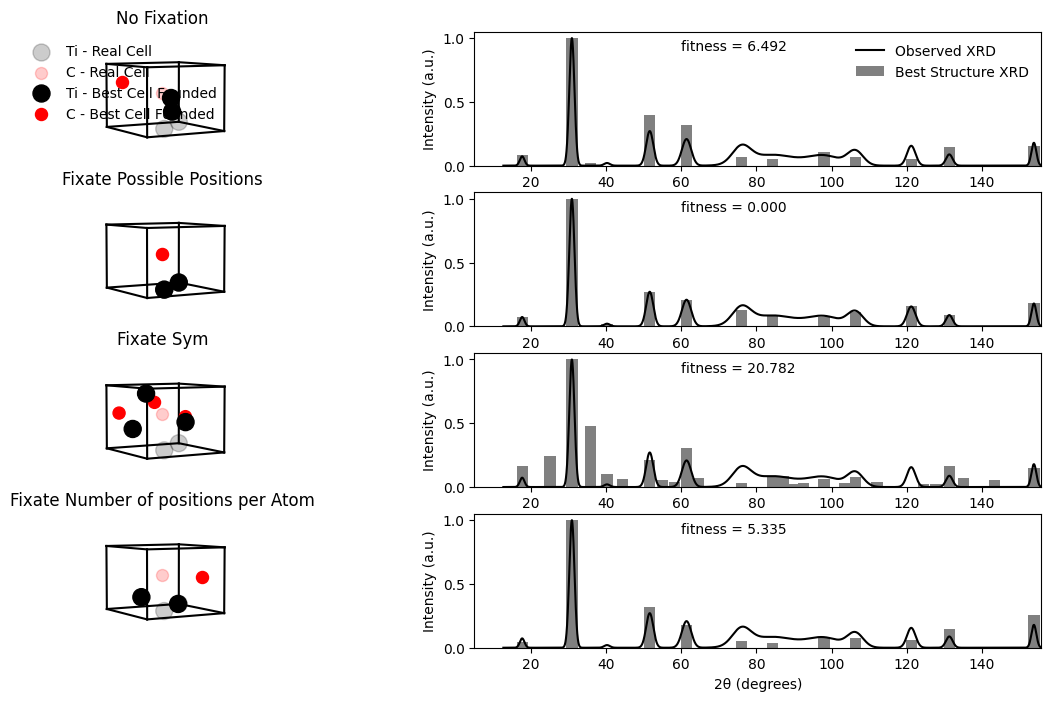

In [273]:
from matplotlib.gridspec import GridSpec


#Make as IF experimental pattern
thes = np.arange(min(observed_theta)-5,max(observed_theta)+5,0.01)
sum = 0
for i in range(len(observed_theta)):
    FWHM = 0.9 * lamb / (1 * np.cos(np.radians(observed_theta[i])))  # Scherrer
    sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to sigma
    sum += U[i] * np.exp(-((thes - observed_theta[i])**2) / (2 * sigma**2))
sum = sum/max(sum)


#Define for plot
Z = {'Ti':30,'C':15}
colors = {'Ti':'black','C':'red'}
#begin plot
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(4, 2, width_ratios=[1, 1] , wspace=0.05,hspace = 0.2)
    # --- 3D Structure Plot (Left) ---
ax1 = fig.add_subplot(gs[0], projection='3d')  # 3D plot
    
    # Plot IDEAL structure (semi-transparent)
POS = model1.positions
Atoms = model1.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=0.2, label = f'{Atoms[i]} - Real Cell')
    
# Plot BEST structure (current generation)
POS = Best_cell_no.positions
Atoms = Best_cell_no.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=1, label = f'{Atoms[i]} - Best Cell Founded')
pyXRDCodes.UNIT_CELL_PLOT(ax1,unit_params,unit_angles,xyz=False)
    
#ax1.set_title(f"Generation {gen}\nBest Structure (Red) vs. Ideal (Transparent)")
ax1.legend(frameon=False,loc='upper right')
ax1.set_axis_off()
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_zlim(0,1)
ax1.view_init(elev=5, azim=60)  
ax1.set_title('No Fixation')
# --- XRD Comparison Plot (Right) ---
ax2 = fig.add_subplot(gs[1])  # 3D plot
    
# Calculate XRD for the best cell
theta_best, int_best = Best_cell_no.calculate_xrd(lamb)
 
# Plot observed and simulated XRD
ax2.plot(thes, sum, color='black', label='Observed XRD')
ax2.bar(theta_best, int_best, color='gray',width=  3, label='Best Structure XRD')
ax2.set_xlabel('2θ (degrees)')
ax2.set_ylabel('Intensity (a.u.)')
ax2.set_xlim(5,max(observed_theta)+2)
ax2.legend(loc ='upper right',frameon=False)
ax2.annotate(f'fitness = {compute_fitness(Best_cell_no,observed_theta,U,lamb,peak_tol=0.01):.3f}'
             ,xy=(60,0.9),xytext=(60,0.9))
#==================================================
    # --- 3D Structure Plot (Left) ---
ax1 = fig.add_subplot(gs[2], projection='3d')  # 3D plot
    
    # Plot IDEAL structure (semi-transparent)
POS = model1.positions
Atoms = model1.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=0.2, label = f'{Atoms[i]} - Real Cell')
    
# Plot BEST structure (current generation)
POS = Best_cell_pos.positions
Atoms = Best_cell_pos.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=1, label = f'{Atoms[i]} - Best Cell Founded')
pyXRDCodes.UNIT_CELL_PLOT(ax1,unit_params,unit_angles,xyz=False)
    
#ax1.set_title(f"Generation {gen}\nBest Structure (Red) vs. Ideal (Transparent)")
#ax1.legend(frameon=False,loc='upper right')
ax1.set_axis_off()
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_zlim(0,1)
ax1.view_init(elev=5, azim=60)  
ax1.set_title('Fixate Possible Positions')
# --- XRD Comparison Plot (Right) ---
ax2 = fig.add_subplot(gs[3])  # 3D plot
    
# Calculate XRD for the best cell
theta_best, int_best = Best_cell_pos.calculate_xrd(lamb)
 
# Plot observed and simulated XRD
ax2.plot(thes, sum, color='black', label='Observed XRD')
ax2.bar(theta_best, int_best, color='gray',width=  3, label='Best Structure XRD')
ax2.set_xlabel('2θ (degrees)')
ax2.set_ylabel('Intensity (a.u.)')
ax2.set_xlim(5,max(observed_theta)+2)
ax2.annotate(f'fitness = {compute_fitness(Best_cell_pos,observed_theta,U,lamb,peak_tol=0.01):.3f}'
             ,xy=(60,0.9),xytext=(60,0.9))
#==================================================
    # --- 3D Structure Plot (Left) ---
ax1 = fig.add_subplot(gs[4], projection='3d')  # 3D plot
    
    # Plot IDEAL structure (semi-transparent)
POS = model1.positions
Atoms = model1.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=0.2, label = f'{Atoms[i]} - Real Cell')
    
# Plot BEST structure (current generation)
POS = Best_cell_symm.positions
Atoms = Best_cell_symm.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=1, label = f'{Atoms[i]} - Best Cell Founded')
pyXRDCodes.UNIT_CELL_PLOT(ax1,unit_params,unit_angles,xyz=False)
    
#ax1.set_title(f"Generation {gen}\nBest Structure (Red) vs. Ideal (Transparent)")
#ax1.legend(frameon=False,loc='upper right')
ax1.set_axis_off()
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_zlim(0,1)
ax1.view_init(elev=5, azim=60)  
ax1.set_title('Fixate Sym')
# --- XRD Comparison Plot (Right) ---
ax2 = fig.add_subplot(gs[5])  # 3D plot
    
# Calculate XRD for the best cell
theta_best, int_best = Best_cell_symm.calculate_xrd(lamb)
 
# Plot observed and simulated XRD
ax2.plot(thes, sum, color='black', label='Observed XRD')
ax2.bar(theta_best, int_best, color='gray',width=  3, label='Best Structure XRD')
ax2.set_xlabel('2θ (degrees)')
ax2.set_ylabel('Intensity (a.u.)')
ax2.set_xlim(5,max(observed_theta)+2)
ax2.annotate(f'fitness = {compute_fitness(Best_cell_symm,observed_theta,U,lamb,peak_tol=0.01):.3f}'
             ,xy=(60,0.9),xytext=(60,0.9))

#==================================================
    # --- 3D Structure Plot (Left) ---
ax1 = fig.add_subplot(gs[6], projection='3d')  # 3D plot
    
    # Plot IDEAL structure (semi-transparent)
POS = model1.positions
Atoms = model1.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=0.2, label = f'{Atoms[i]} - Real Cell')
    
# Plot BEST structure (current generation)
POS = Best_cell_numb.positions
Atoms = Best_cell_numb.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=1, label = f'{Atoms[i]} - Best Cell Founded')
pyXRDCodes.UNIT_CELL_PLOT(ax1,unit_params,unit_angles,xyz=False)
    
#ax1.set_title(f"Generation {gen}\nBest Structure (Red) vs. Ideal (Transparent)")
#ax1.legend(frameon=False,loc='upper right')
ax1.set_axis_off()
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_zlim(0,1)
ax1.view_init(elev=5, azim=60)  
ax1.set_title('Fixate Number of positions per Atom')
# --- XRD Comparison Plot (Right) ---
ax2 = fig.add_subplot(gs[7])  # 3D plot
    
# Calculate XRD for the best cell
theta_best, int_best = Best_cell_numb.calculate_xrd(lamb)
 
# Plot observed and simulated XRD
ax2.plot(thes, sum, color='black', label='Observed XRD')
ax2.bar(theta_best, int_best, color='gray',width=  3, label='Best Structure XRD')
ax2.set_xlabel('2θ (degrees)')
ax2.set_ylabel('Intensity (a.u.)')
ax2.set_xlim(5,max(observed_theta)+2)
ax2.annotate(f'fitness = {compute_fitness(Best_cell_numb,observed_theta,U,lamb,peak_tol=0.01):.3f}'
             ,xy=(60,0.9),xytext=(60,0.9))
plt.tight_layout()
plt.savefig('Figuras/Structure_Changing.svg')

---

In [ ]:
lamb = 1.54
atoms = ['Ti','C']
positions = [ [[0,0,0],[1/2,1/2,0] ] , [[1/4,0,1/2]] ]
unit_params = [3,3,18]
unit_angles = [90,90,120]
structure = 'hexagonal'
symm = 194
hkls, counts, thetas, Gs = pyXRDCodes.generate_hkls(lamb,10, np.array(unit_params), np.array(unit_angles)) #<--- edited here
model1 = Structure( atoms, positions,symm, unit_params,unit_angles,thetas,hkls,counts,step=0.01,group_sym = [194])
observed_theta,U = model1.calculate_xrd(lamb)
thes = np.arange(min(observed_theta)-2,max(observed_theta)+2,0.1)
compute_fitness(model1 , observed_theta,U , lamb,2 )

In [ ]:
lamb = 1.54
atoms = ['Ti','C']
positions = [ [[0,0,0],[1/2,1/2,0] ] , [[1/4,0,1/2]] ]
unit_params = [7,5,12]
unit_angles = [70,85,110]
structure = 'triclinic'
symm = 2
hkls, counts, thetas, Gs = pyXRDCodes.generate_hkls(lamb,10, np.array(unit_params), np.array(unit_angles)) #<--- edited here
model1 = Structure( atoms, positions,symm, unit_params,unit_angles,thetas,hkls,counts,step=0.01,group_sym = [2])
observed_theta,U = model1.calculate_xrd(lamb)
thes = np.arange(min(observed_theta)-2,max(observed_theta)+2,0.1)
compute_fitness(model1 , observed_theta,U , lamb,2 )

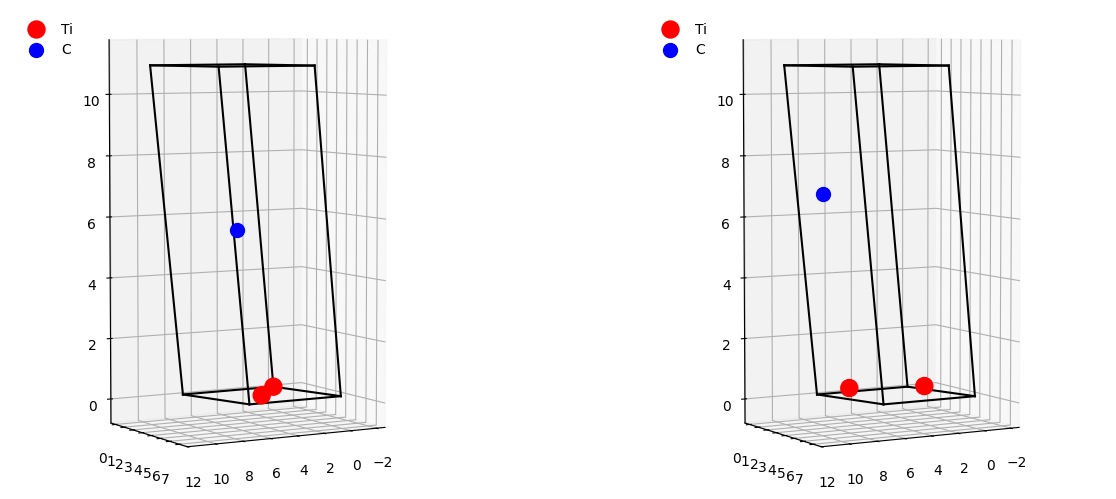

In [96]:
# Cria a figura e os subplots
fig = plt.figure(figsize=(15, 6))
gs = GridSpec(1, 2)
ax2 = fig.add_subplot(gs[0], projection='3d')  # 3D plot
ax4 = fig.add_subplot(gs[1], projection='3d')  # 3D plot
colors = ['red','blue']
Z = [30,20]

# Inicializa o plot 3D
POS__ = model1.get_primit_unit()[0]

# Extract x, y, z coordinates
points = POS__[0]
x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
ax2.scatter(x, y, z,s=5 * Z[0], color=colors[0],alpha=1, label = f'{model1.atoms[0]}')
points = POS__[1]
x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
ax2.scatter(x, y, z,s=5 * Z[1], color=colors[1],alpha=1, label = f'{model1.atoms[1]}')
#pyXRDCodes.UNIT_CELL_PLOT_HEXAGON(ax2, unit_params, unit_angles)
pyXRDCodes.UNIT_CELL_PLOT(ax2, model1.unit_params, model1.unit_angles,[1,1,1],xyz=True)
    
ax2.set_box_aspect((model1.unit_params[0], model1.unit_params[1], model1.unit_params[2]  ))
ax2.view_init(elev=5, azim=60)
ax2.legend(frameon=False,loc='upper left')

# Inicializa o plot 3D
POS__ = Best_cell.get_primit_unit()[0]
xs = [arr[0] for sublista in POS__ for arr in sublista]
ys = [arr[1] for sublista in POS__ for arr in sublista]
zs = [arr[2] for sublista in POS__ for arr in sublista]


# Extract x, y, z coordinates
points = POS__[0]
x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
ax4.scatter(x, y, z,s=5 * Z[0], color=colors[0],alpha=1, label = f'{Best_cell.atoms[0]}')
points = POS__[1]
x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
ax4.scatter(x, y, z,s=5 * Z[1], color=colors[1],alpha=1, label = f'{Best_cell.atoms[1]}')
pyXRDCodes.UNIT_CELL_PLOT(ax4, Best_cell.unit_params, Best_cell.unit_angles,[1,1,1])


ax4.set_box_aspect((Best_cell.unit_params[0], Best_cell.unit_params[1], Best_cell.unit_params[2]  ))
ax4.view_init(elev=5, azim=60)
ax4.legend(frameon=False,loc='upper left')


plt.show()

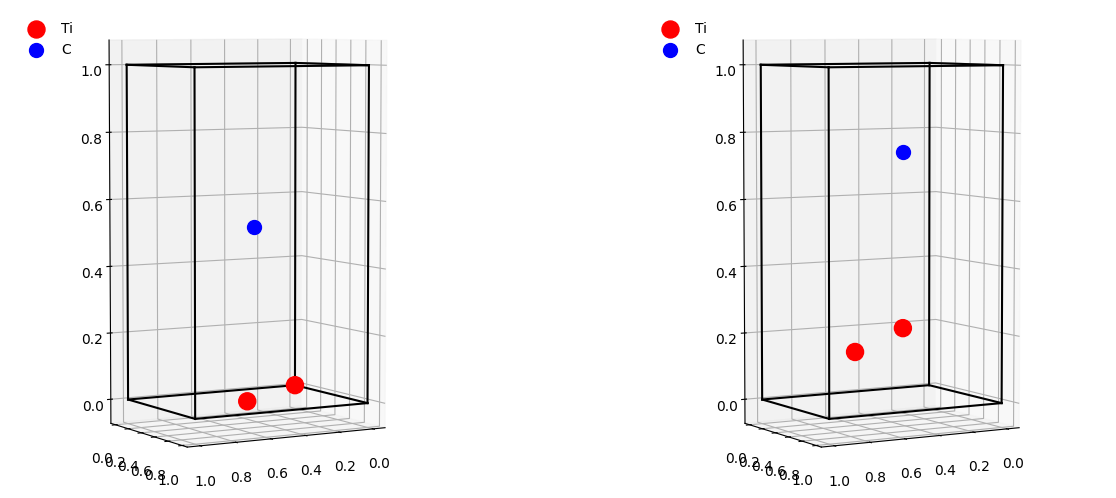

In [104]:
# Cria a figura e os subplots
fig = plt.figure(figsize=(15, 6))
gs = GridSpec(1, 2)
ax2 = fig.add_subplot(gs[0], projection='3d')  # 3D plot
ax4 = fig.add_subplot(gs[1], projection='3d')  # 3D plot
colors = ['red','blue']
Z = [30,20]

# Inicializa o plot 3D
POS__ = model1.positions#model1.true_positions(model1.positions)

# Extract x, y, z coordinates
points = POS__[0]
x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
ax2.scatter(x, y, z,s=5 * Z[0], color=colors[0],alpha=1, label = f'{model1.atoms[0]}')
points = POS__[1]
x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
ax2.scatter(x, y, z,s=5 * Z[1], color=colors[1],alpha=1, label = f'{model1.atoms[1]}')
#pyXRDCodes.UNIT_CELL_PLOT_HEXAGON(ax2, unit_params, unit_angles)
pyXRDCodes.UNIT_CELL_PLOT(ax2, model1.unit_params, model1.unit_angles,[1,1,1],xyz=False)
    
ax2.set_box_aspect((model1.unit_params[0], model1.unit_params[1], model1.unit_params[2]  ))
ax2.view_init(elev=5, azim=60)
ax2.legend(frameon=False,loc='upper left')

# Inicializa o plot 3D
POS__ = Best_cell.positions#Best_cell.true_positions(Best_cell.positions)
xs = [arr[0] for sublista in POS__ for arr in sublista]
ys = [arr[1] for sublista in POS__ for arr in sublista]
zs = [arr[2] for sublista in POS__ for arr in sublista]


# Extract x, y, z coordinates
points = POS__[0]
x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
ax4.scatter(x, y, z,s=5 * Z[0], color=colors[0],alpha=1, label = f'{Best_cell.atoms[0]}')
points = POS__[1]
x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
ax4.scatter(x, y, z,s=5 * Z[1], color=colors[1],alpha=1, label = f'{Best_cell.atoms[1]}')
pyXRDCodes.UNIT_CELL_PLOT(ax4, Best_cell.unit_params, Best_cell.unit_angles,[1,1,1],xyz=False)


ax4.set_box_aspect((Best_cell.unit_params[0], Best_cell.unit_params[1], Best_cell.unit_params[2]  ))
ax4.view_init(elev=5, azim=60)
ax4.legend(frameon=False,loc='upper left')


plt.show()

In [98]:
print(Best_cell.positions)
print(Best_cell.symnumb)
print(model1.positions)
print(model1.symnumb)


[[[0.31, 0.68, 0.03], [0.77, 0.18, 0.02]], [[0.85, 0.17, 0.62]]]
1
[[[0, 0, 0], [0.5, 0.5, 0]], [[0.25, 0, 0.5]]]
2


In [99]:
print(Best_cell.true_positions(Best_cell.positions))
print(Best_cell.symnumb)
print(model1.true_positions(model1.positions))
print(model1.symnumb)


[[array([1.13025876, 3.27315928, 0.32912575]), array([5.16426671, 0.8978596 , 0.21941716])], [array([8.20391274, 2.41496234, 6.80193209])]]
1
[[array([0., 0., 0.]), array([2.64494964, 2.34923155, 0.        ])], [array([3.80212086, 1.30340614, 5.4854291 ])]]
2


In [101]:
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

def create_animation(Best_Hist, model1, observed_theta, U, lamb, unit_params, unit_angles, Z):
    # Prepare experimental XRD pattern
    thes = np.arange(min(observed_theta)-5, max(observed_theta)+5, 0.01)
    sum_int = np.zeros_like(thes)
    
    for i in range(len(observed_theta)):
        FWHM = 0.9 * lamb / (1 * np.cos(np.radians(observed_theta[i])))
        sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
        sum_int += U[i] * np.exp(-((thes - observed_theta[i])**2) / (2 * sigma**2))
    sum_int = sum_int/max(sum_int)

    # Define colors and initialize figure
    colors = ['red', 'black', 'gray']
    fig = plt.figure(figsize=(12, 6))
    
    # --- 3D Structure Plot (Left) ---
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Plot IDEAL structure (semi-transparent, static)
    POS_ideal = model1.positions
    Atoms_ideal = model1.atoms
    for i in range(len(POS_ideal)):
        points = POS_ideal[i]
        x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
        ax1.scatter(x, y, z, s=5*Z[i], color=colors[i], alpha=0.2, label=f'{Atoms_ideal[i]} (ideal)')
    
    # Create empty scatter plots for current structure (will be updated)
    current_scatters = []
    for i in range(len(Best_Hist[0].atoms)):  # Assuming max 3 atom types
        sc = ax1.scatter([], [], [], s=5*Z[i], color=colors[i], alpha=1.0, label=f'{Atoms_ideal[i]} (current)')
        current_scatters.append(sc)
    
    # Add unit cell
    pyXRDCodes.UNIT_CELL_PLOT(ax1, unit_params, unit_angles, xyz=False)
    ax1.set_axis_off()
    ax1.view_init(elev=5, azim=60)
    ax1.legend()
    
    # --- XRD Comparison Plot (Right) ---
    ax2 = fig.add_subplot(122)
    
    # Plot experimental XRD (static)
    ax2.plot(thes, sum_int, color='black', label='Observed XRD')
    
    # Create empty bar plot for current XRD (will be updated)
    xrd_bars = []#ax2.bar([], [], width=3, color='gray', alpha=0.7, label='Current Structure XRD')
    ax2.set_xlabel('2θ (degrees)')
    ax2.set_ylabel('Intensity (a.u.)')
    ax2.set_xlim(thes[0],thes[-1])
    ax2.legend()
    ax2.set_title("XRD Comparison")
    
    plt.tight_layout()

    def init():
        """Initialize animation with empty current structure"""
        for sc in current_scatters:
            sc._offsets3d = (np.array([]), np.array([]), np.array([]))
        
        for bar in xrd_bars:#.patches:
            bar.remove()
            #bar.set_height(0)
        xrd_bars.clear()
            
        return current_scatters #+ xrd_bars.patches

    def update(gen):
        """Update plot for current generation"""
        current_cell = Best_Hist[gen]
        
        # Update atomic positions
        POS_current = current_cell.positions
        Atoms_current = current_cell.atoms
        
        # Clear previous positions
        for sc in current_scatters:
            sc._offsets3d = (np.array([]), np.array([]), np.array([]))
        
        # Update with current positions
        for i in range(len(Atoms_current)):
            points = POS_current[i]
            x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
            current_scatters[i]._offsets3d = (x, y, z)
        
        # Update XRD bars
        theta_best, int_best = current_cell.calculate_xrd(lamb)
        
        # Clear previous bars
        #for bar in xrd_bars.patches:
        #    bar.set_height(0)
        for bar in xrd_bars:
            bar.remove()
        xrd_bars.clear()
        # Update bar heights and positions
        for i, (theta, intensity) in enumerate(zip(theta_best, int_best)):
            bar = ax2.bar(theta, intensity, width=3, color='gray', alpha=0.7)[0]
            xrd_bars.append(bar)
            #if i < len(xrd_bars.patches):
            #    xrd_bars.patches[i].set_x(theta - 1.5)  # Center the bar (width=3)
            #    xrd_bars.patches[i].set_height(intensity)
            #else:
                # Add new bars if needed (should be rare)
            #    ax2.bar(theta, intensity, width=3, color='gray', alpha=0.7)
        
        # Update title
        fig.suptitle(f'Generation {gen}', y=1.0)
        
        return current_scatters + xrd_bars#list(xrd_bars.patches)

    # Create animation
    anim = FuncAnimation(
        fig, update, frames=len(Best_Hist),
        init_func=init, blit=True, interval=200
    )
    
    return anim

# Usage:
anim = create_animation(Best_Hist, model1, observed_theta, U, lamb, unit_params, unit_angles, Z)
anim.save('ga_evolution_notfixated2.mp4', writer='ffmpeg', dpi=150)
plt.close()
print("Animation saved!")

Animation saved!


# Testes

In [23]:
lamb = 1.54
atoms = ['Nb','C']
positions = [ [[0,0,0],[1/2,1/2,0] ] , [[1/4,0,1/2]] ]
unit_params = [3,3,18]
unit_angles = [90,90,120]
structure = 'hexagonal'
symm = 194
hkls, counts, thetas, Gs = pyXRDCodes.generate_hkls(lamb,10, np.array(unit_params), np.array(unit_angles)) #<--- edited here
model1 = Structure( atoms, positions,symm, unit_params,unit_angles,structure,thetas,hkls,counts)
observed_theta,U = model1.calculate_xrd(lamb)
compute_fitness(model1 , observed_theta,U , lamb,2 )

0.0

In [33]:
Best_cell,Hist_Score,Best_Hist = run_ga(observed_theta,
        U,
        2,
        lamb,
        atoms,
        unit_params,
        unit_angles,
        structure,
        generations = 350,
        numb_pop = 150,
        elit_frac = 0.3,
        add_prob = 0.1,
        take_prob = 0.1,
        change_prob = 0.7,
        change_sym = 0.5,
        inherit_prob = 0.5,
        early_stag = 7,
        shuffle_prob=0.2,
        change_atom=0.4,
        max_shift = 25,
        limit_min = compute_fitness(model1 , observed_theta,U , lamb,2)-0.1,
        bounds = [5,100])

Generation 1, Best Fitness: 3.051
Generation 2, Best Fitness: 3.051
Generation 3, Best Fitness: 1.786
Generation 4, Best Fitness: 0.933
Generation 5, Best Fitness: 0.933
Generation 6, Best Fitness: 0.933
Generation 7, Best Fitness: 0.933
Generation 8, Best Fitness: 0.933
Generation 9, Best Fitness: 0.933
Stagnation found at 10
Generation 10, Best Fitness: 0.718
Generation 11, Best Fitness: 0.718
Generation 12, Best Fitness: 0.718
Generation 13, Best Fitness: 0.718
Generation 14, Best Fitness: 0.202
Generation 15, Best Fitness: 0.202
Generation 16, Best Fitness: 0.202
Generation 17, Best Fitness: 0.202
Generation 18, Best Fitness: 0.202
Generation 19, Best Fitness: 0.202
Stagnation found at 20
Generation 20, Best Fitness: 0.202
Generation 21, Best Fitness: 0.202
Generation 22, Best Fitness: 0.202
Generation 23, Best Fitness: 0.202
Generation 24, Best Fitness: 0.202
Generation 25, Best Fitness: 0.202
Stagnation found at 26
Generation 26, Best Fitness: 0.191
Generation 27, Best Fitness: 0

In [34]:
lamb = 1.54
atoms2 = ['Nb','C']
positions2 = [ [[0,0,0],[1/2,1/2,0] ] , [[1/4,0,1/2]] ]
unit_params2 = [5,5,5]
unit_angles2 = [90,90,90]
structure2 = 'cubic'
symm2 = 210
hkls, counts, thetas, Gs = pyXRDCodes.generate_hkls(lamb,10, np.array(unit_params2), np.array(unit_angles2)) #<--- edited here
model2 = Structure( atoms2, positions2,symm2, unit_params2,unit_angles2,structure2,thetas,hkls,counts)
observed_theta2,U2 = model2.calculate_xrd(lamb)
compute_fitness(model2 , observed_theta2,U2 , lamb,2 )

0.0

In [35]:
Best_cell2,Hist_Score2,Best_Hist2 = run_ga(observed_theta2,
        U2,
        3,
        lamb,
        atoms2,
        unit_params2,
        unit_angles2,
        structure2,
        generations = 350,
        numb_pop = 150,
        elit_frac = 0.3,
        add_prob = 0.1,
        take_prob = 0.1,
        change_prob = 0.7,
        change_sym = 0.5,
        inherit_prob = 0.5,
        early_stag = 7,
        shuffle_prob=0.2,
        change_atom=0.4,
        max_shift = 25,
        limit_min = compute_fitness(model2 , observed_theta2,U2 , lamb,3)-0.1,
        bounds = [5,100])

Generation 1, Best Fitness: 23.129
Generation 2, Best Fitness: 23.129
Generation 3, Best Fitness: 18.511
Generation 4, Best Fitness: 18.511
Generation 5, Best Fitness: 18.511
Generation 6, Best Fitness: 18.511
Generation 7, Best Fitness: 18.511
Generation 8, Best Fitness: 13.186
Generation 9, Best Fitness: 13.186
Generation 10, Best Fitness: 13.186
Generation 11, Best Fitness: 13.186
Generation 12, Best Fitness: 10.151
Generation 13, Best Fitness: 10.151
Generation 14, Best Fitness: 10.151
Generation 15, Best Fitness: 10.151
Generation 16, Best Fitness: 10.151
Generation 17, Best Fitness: 10.151
Stagnation found at 18
Generation 18, Best Fitness: 9.194
Generation 19, Best Fitness: 9.194
Generation 20, Best Fitness: 9.194
Generation 21, Best Fitness: 8.666
Generation 22, Best Fitness: 8.666
Generation 23, Best Fitness: 8.666
Generation 24, Best Fitness: 8.666
Generation 25, Best Fitness: 8.666
Generation 26, Best Fitness: 8.666
Stagnation found at 27
Generation 27, Best Fitness: 7.458
G

C:\Users\user\AppData\Local\Temp\ipykernel_12260\1087099159.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


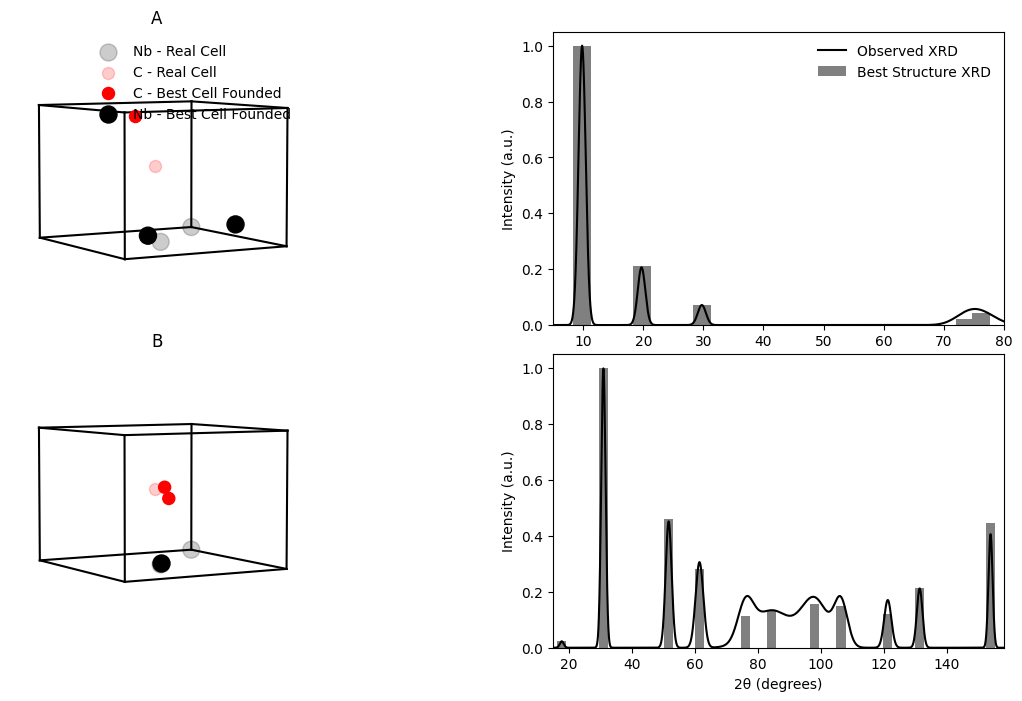

In [36]:
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec


#Make as IF experimental pattern
thes = np.arange(min(observed_theta)-5,max(observed_theta)+5,0.01)
sum = 0
for i in range(len(observed_theta)):
    FWHM = 0.9 * lamb / (1 * np.cos(np.radians(observed_theta[i])))  # Scherrer
    sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to sigma
    sum += U[i] * np.exp(-((thes - observed_theta[i])**2) / (2 * sigma**2))
sum = sum/max(sum)
#Make as IF experimental pattern
thes2 = np.arange(min(observed_theta2)-5,max(observed_theta2)+5,0.01)
sum2 = 0
for i in range(len(observed_theta2)):
    FWHM = 0.9 * lamb / (1 * np.cos(np.radians(observed_theta2[i])))  # Scherrer
    sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to sigma
    sum2 += U2[i] * np.exp(-((thes2 - observed_theta2[i])**2) / (2 * sigma**2))
sum2 = sum2/max(sum2)


#Define for plot
Z = {'Nb':30,'C':15}
colors = {'Nb':'black','C':'red'}
#begin plot
fig = plt.figure(figsize=(15, 8))
gs = GridSpec(2, 2, width_ratios=[1.4, 1], height_ratios=[1, 1], 
              wspace=0.15, hspace=0.1)
    # --- 3D Structure Plot (Left) ---
ax1 = fig.add_subplot(gs[0], projection='3d')  # 3D plot
    
    # Plot IDEAL structure (semi-transparent)
POS = model1.positions
Atoms = model1.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=0.2, label = f'{Atoms[i]} - Real Cell')
    
# Plot BEST structure (current generation)
POS = Best_cell.positions
Atoms = Best_cell.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=1, label = f'{Atoms[i]} - Best Cell Founded')
pyXRDCodes.UNIT_CELL_PLOT(ax1,unit_params,unit_angles,xyz=False)
    
#ax1.set_title(f"Generation {gen}\nBest Structure (Red) vs. Ideal (Transparent)")
ax1.legend(frameon=False,loc='upper right')
ax1.set_axis_off()
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_zlim(0,1)
ax1.view_init(elev=5, azim=60)  
ax1.set_title('A')

ax1 = fig.add_subplot(gs[2], projection='3d')  # 3D plot
    # Plot IDEAL structure (semi-transparent)
POS = model2.positions
Atoms = model2.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=0.2, label = f'{Atoms[i]} - Real Cell')
    
# Plot BEST structure (current generation)
POS = Best_cell2.positions
Atoms = Best_cell2.atoms
for i in range(len(POS)):
    #Start by plotting the structure
    points = POS[i] 
    x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
    ax1.scatter(x, y, z,s=5 * Z[Atoms[i]], color=colors[Atoms[i]],alpha=1, label = f'{Atoms[i]} - Best Cell Founded')
pyXRDCodes.UNIT_CELL_PLOT(ax1,unit_params2,unit_angles2,xyz=False)
    
#ax1.set_title(f"Generation {gen}\nBest Structure (Red) vs. Ideal (Transparent)")
#ax1.legend(frameon=False)
ax1.set_axis_off()
ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_zlim(0,1)
ax1.view_init(elev=5, azim=60)  
ax1.set_title('B')
# --- XRD Comparison Plot (Right) ---
ax2 = fig.add_subplot(gs[1])  # 3D plot
    
# Calculate XRD for the best cell
theta_best, int_best = Best_cell.calculate_xrd(lamb)
 
# Plot observed and simulated XRD
ax2.plot(thes, sum, color='black', label='Observed XRD')
ax2.bar(theta_best, int_best, color='gray',width=  3, label='Best Structure XRD')
ax2.set_xlabel('2θ (degrees)')
ax2.set_ylabel('Intensity (a.u.)')
ax2.set_xlim(5,80)
ax2.legend(loc ='upper right',frameon=False)

    
ax2 = fig.add_subplot(gs[3])  
    
# Calculate XRD for the best cell
theta_best, int_best = Best_cell2.calculate_xrd(lamb)
 
# Plot observed and simulated XRD
ax2.plot(thes2, sum2, color='black', label='Observed XRD')
ax2.bar(theta_best, int_best, color='gray',width=  3, label='Best Structure XRD')
ax2.set_xlabel('2θ (degrees)')
ax2.set_ylabel('Intensity (a.u.)')
#ax2.legend()
ax2.set_xlim(15,158)

plt.tight_layout()
plt.savefig('Figuras/Structures_exemp.svg')

In [37]:
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

def create_animation(Best_Hist, model1, observed_theta, U, lamb, unit_params, unit_angles, Z):
    # Prepare experimental XRD pattern
    thes = np.arange(min(observed_theta)-5, max(observed_theta)+5, 0.01)
    sum_int = np.zeros_like(thes)
    
    for i in range(len(observed_theta)):
        FWHM = 0.9 * lamb / (1 * np.cos(np.radians(observed_theta[i])))
        sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
        sum_int += U[i] * np.exp(-((thes - observed_theta[i])**2) / (2 * sigma**2))
    sum_int = sum_int/max(sum_int)

    # Define colors and initialize figure
    Z = {f'{Best_cell.atoms[0]}':30,f'{Best_cell.atoms[1]}':15}
    colors = {f'{Best_cell.atoms[0]}':'black',f'{Best_cell.atoms[1]}':'red'}   
    fig = plt.figure(figsize=(12, 6))
    
    # --- 3D Structure Plot (Left) ---
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Plot IDEAL structure (semi-transparent, static)
    POS_ideal = model1.positions
    Atoms_ideal = model1.atoms
    for i in range(len(POS_ideal)):
        points = POS_ideal[i]
        x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
        ax1.scatter(x, y, z, s=5*Z[Atoms_ideal[i]], color=colors[Atoms_ideal[i]], alpha=0.2, label=f'{Atoms_ideal[i]} (ideal)')
    
    # Create empty scatter plots for current structure (will be updated)
    current_scatters = []
    for i in range(len(Best_Hist[0].atoms)):  # Assuming max 3 atom types
        sc = ax1.scatter([], [], [], s=5*Z[Best_Hist[0].atoms[i]], color=colors[Best_Hist[0].atoms[i]], alpha=1.0, label=f'{Atoms_ideal[i]} (current)')
        current_scatters.append(sc)
    
    # Add unit cell
    pyXRDCodes.UNIT_CELL_PLOT(ax1, unit_params, unit_angles, xyz=False)
    ax1.set_axis_off()
    ax1.view_init(elev=5, azim=60)
    #ax1.legend()
    
    # --- XRD Comparison Plot (Right) ---
    ax2 = fig.add_subplot(122)
    
    # Plot experimental XRD (static)
    ax2.plot(thes, sum_int, color='black', label='Observed XRD')
    
    # Create empty bar plot for current XRD (will be updated)
    xrd_bars = []#ax2.bar([], [], width=3, color='gray', alpha=0.7, label='Current Structure XRD')
    ax2.set_xlabel('2θ (degrees)')
    ax2.set_ylabel('Intensity (a.u.)')
    ax2.set_xlim(thes[0],thes[-1])
    ax2.legend()
    ax2.set_title("XRD Comparison")
    
    plt.tight_layout()

    def init():
        """Initialize animation with empty current structure"""
        for sc in current_scatters:
            sc._offsets3d = (np.array([]), np.array([]), np.array([]))
        
        for bar in xrd_bars:#.patches:
            bar.remove()
            #bar.set_height(0)
        xrd_bars.clear()
            
        return current_scatters #+ xrd_bars.patches

    def update(gen):
        """Update plot for current generation"""
        current_cell = Best_Hist[gen]
        
        # Update atomic positions
        POS_current = current_cell.positions
        Atoms_current = current_cell.atoms
        
        # Clear previous positions
        for sc in current_scatters:
            sc._offsets3d = (np.array([]), np.array([]), np.array([]))
        
        # Update with current positions
        for i in range(len(Atoms_current)):
            points = POS_current[i]
            x, y, z = np.array(points)[:, 0], np.array(points)[:, 1], np.array(points)[:, 2]
            current_scatters[i]._offsets3d = (x, y, z)
        
        # Update XRD bars
        theta_best, int_best = current_cell.calculate_xrd(lamb)
        
        # Clear previous bars
        #for bar in xrd_bars.patches:
        #    bar.set_height(0)
        for bar in xrd_bars:
            bar.remove()
        xrd_bars.clear()
        # Update bar heights and positions
        for i, (theta, intensity) in enumerate(zip(theta_best, int_best)):
            bar = ax2.bar(theta, intensity, width=3, color='gray', alpha=0.7)[0]
            xrd_bars.append(bar)
            #if i < len(xrd_bars.patches):
            #    xrd_bars.patches[i].set_x(theta - 1.5)  # Center the bar (width=3)
            #    xrd_bars.patches[i].set_height(intensity)
            #else:
                # Add new bars if needed (should be rare)
            #    ax2.bar(theta, intensity, width=3, color='gray', alpha=0.7)
        
        # Update title
        fig.suptitle(f'Generation {gen}', y=1.0)
        
        return current_scatters + xrd_bars#list(xrd_bars.patches)

    # Create animation
    anim = FuncAnimation(
        fig, update, frames=len(Best_Hist),
        init_func=init, blit=True, interval=200
    )
    
    return anim

# Usage:
anim = create_animation(Best_Hist, model1, observed_theta, U, lamb, unit_params, unit_angles, Z)
anim.save('Figuras/show.gif', writer='ffmpeg', dpi=150)
plt.close()
print("Animation saved!")

Animation saved!


In [38]:
# Usage:
anim = create_animation(Best_Hist2, model2, observed_theta2, U2, lamb, unit_params2, unit_angles2, Z)
anim.save('Figuras/show2.gif', writer='ffmpeg', dpi=150)
plt.close()
print("Animation saved!")

Animation saved!
